In [1]:
!pip install scikit-image


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


<ipython-input-6-e894b902560d>:70: FutureWarning: `selem` is a deprecated argument name for `reconstruction`. It will be removed in version 1.0. Please use `footprint` instead.
  data_rgb[:, :, i] = morphology.reconstruction(data[:, :, i], data[:, :, i], method='dilation', selem=selem)


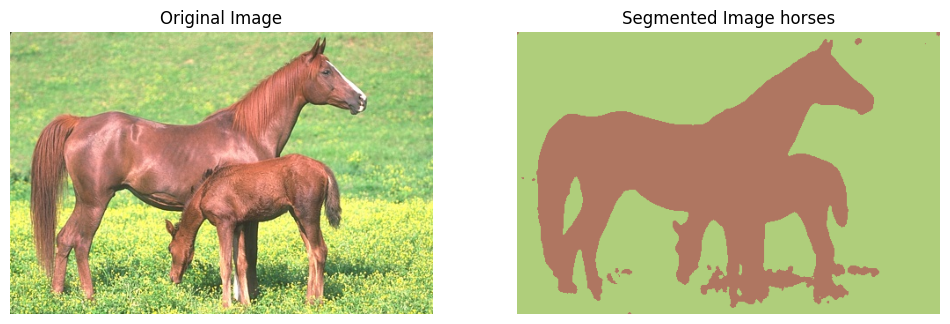

In [6]:
def label_image(image, labels):
    M, N = image.shape[:2]
    num_segments = np.max(labels) + 1  # Adjust for 0-based indexing

    # Prepare output image
    fs = np.zeros_like(image)

    for i in range(num_segments):
        mask = labels == i
        if image.ndim == 3:  # Color image
            for c in range(3):  # For each color channel
                fs[:, :, c][mask] = np.median(image[:, :, c][mask])
        else:  # Grayscale image
            fs[mask] = np.median(image[mask])

    return fs


def fcm_image_color(image, membership_matrices):
    m, n = image.shape[:2]
    num_elements = m * n

    # Check and flatten each membership matrix
    flattened_matrices = []
    for matrix in membership_matrices:
        if matrix.size == num_elements:  # Ensure the matrix has the correct number of elements
            flattened_matrix = matrix.reshape(num_elements, -1)
            flattened_matrices.append(flattened_matrix)
        else:
            raise ValueError("Incorrect shape of membership matrix")

    U = np.concatenate(flattened_matrices, axis=1)

    # Determine the cluster index for each pixel
    idx_f = np.argmax(U, axis=1)

    # Label the image based on the cluster indices
    segmented_image = label_image(image, idx_f.reshape((m, n)))

    return segmented_image

def initialize_membership(data, cluster_n):
    np.random.seed(42)  # For reproducibility
    n_samples = data.shape[0]
    U = np.random.rand(n_samples, cluster_n)
    U = U / np.tile(U.sum(axis=1)[np.newaxis].T, cluster_n)
    return U


import numpy as np
import skimage
from skimage import color, morphology, filters


def frfcm_c(data, cluster_n, radius, w_size, options=None):
    if options is None:
        options = [2, 100, 1e-5, 0]

    expo, max_iter, min_impro, display = options

    if expo <= 1:
        raise ValueError("The exponent should be greater than 1!")

    # Step 1: Morphological reconstruction
    # Step 1: Morphological reconstruction
    selem = morphology.disk(radius)
    if data.ndim == 3 and data.shape[2] == 3:  # Check for color image
        data_rgb = np.empty_like(data)
        for i in range(3):  # Apply reconstruction to each channel
            data_rgb[:, :, i] = morphology.reconstruction(data[:, :, i], data[:, :, i], method='dilation', selem=selem)
    else:
        data_rgb = morphology.reconstruction(data, data, method='dilation', selem=selem)

    data_lab = color.rgb2lab(data_rgb)

    # Step 2: FCM on histogram
    data_l, data_a, data_b = data_lab[:, :, 0], data_lab[:, :, 1], data_lab[:, :, 2]
    data_combined = np.vstack((data_l.ravel(), data_a.ravel(), data_b.ravel())).T

    row, col = data_a.shape
    U = initialize_membership(data_combined, cluster_n)


    # Main loop
    for i in range(max_iter):
        mf = np.power(U, expo)  # mf should be of shape [number of data points, number of clusters]

        # Check shapes for matrix multiplication compatibility
        assert mf.shape[1] == cluster_n
        assert data_combined.shape[0] == mf.shape[0]

        # Correct computation of cluster centers
        center = np.empty((cluster_n, data_combined.shape[1]))
        for j in range(cluster_n):
            numerator = np.sum(data_combined * mf[:, j][:, None], axis=0)
            denominator = np.sum(mf[:, j]) + np.finfo(np.float64).eps
            center[j, :] = numerator / denominator
        dist = np.linalg.norm(data_combined[:, None, :] - center[None, :, :], axis=2)
        obj_fcn = np.sum(dist ** 2 * mf)

        U_new = np.power(dist, -2 / (expo - 1))
        U_new /= np.sum(U_new, axis=1)[:, None] + np.finfo(np.float64).eps

        if i > 0 and np.max(np.abs(U_new - U)) < min_impro:
            break
        U = U_new

    U_filtered = np.zeros_like(U)
    for j in range(cluster_n):
        U_channel = U[:, j].reshape(row, col)  # Access the j-th column and reshape
        U_filtered[:, j] = filters.median(U_channel, morphology.disk(w_size)).ravel()
        U_normalized = U_filtered / (np.sum(U_filtered, axis=0) + np.finfo(np.float64).eps)


    # Convert centers back to RGB
    center_l, center_a, center_b = center[:, 0], center[:, 1], center[:, 2]
    center_lab = np.stack((center_l, center_a, center_b), axis=-1).reshape(-1, 3)
    center_rgb = (color.lab2rgb(center_lab.reshape(-1, 1, 3)) * 255).astype(np.uint8).reshape(-1, 3)

    return center_rgb, U_normalized, obj_fcn, i

# Example usage
data = skimage.io.imread('/content/drive/MyDrive/DATA_FRFCM/Images_BSDS/Images_réelles/horses.jpg')
#
center, U, obj_fcn, iter_n = frfcm_c(data, cluster_n=2, radius=3, w_size=3)

m, n = data.shape[:2]  # Assuming data is your original image

cluster_n=2

membership_matrices = []
for j in range(cluster_n):
    membership_matrix = U[:, j].reshape(m, n)  # Reshape for each cluster
    membership_matrices.append(membership_matrix)


image2=data.astype(np.float64)
segmented=fcm_image_color(data, membership_matrices)
#segmented_image_test = np.mean([membership_matrices[i][:, :] for i in range(2)], axis=0)

import matplotlib.pyplot as plt
from skimage import io


# Display the original and segmented images
plt.figure(figsize=(12, 6))
plt.subplot(1, 2 ,1)
plt.imshow(data.astype(np.uint8))
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(segmented)
plt.title('Segmented Image horses')
plt.axis('off')
# Save the color image
plt.imsave('/content/drive/MyDrive/DATA_FRFCM/Results_segmentation_BSDS/segmented_horses.png', segmented)
plt.show()

In [19]:
def calculate_segmentation_accuracy(segmented_image, ground_truth):
    # Check if the images have the same dimensions
    if segmented_image.shape != ground_truth.shape:
        raise ValueError("Segmented image and ground truth must have the same dimensions")

    total_pixels = segmented_image.size
    num_clusters = max(segmented_image.max(), ground_truth.max()) + 1

    accuracy = 0

    for cluster_num in range(num_clusters):
        # Create masks for the current cluster for both images
        segmented_cluster = segmented_image == cluster_num
        ground_truth_cluster = ground_truth == cluster_num

        # Calculate the intersection
        intersection = np.logical_and(segmented_cluster, ground_truth_cluster)
        accuracy += np.sum(intersection)

    return accuracy / total_pixels

import numpy as np

import numpy as np

def calculate_overall_mcc(segmented_image, ground_truth):
    if segmented_image.shape != ground_truth.shape:
        raise ValueError("Segmented image and ground truth must have the same dimensions")

    TP = np.sum((segmented_image == ground_truth) & (ground_truth != 0)).astype(np.int64)
    TN = np.sum((segmented_image == ground_truth) & (ground_truth == 0)).astype(np.int64)
    FP = np.sum((segmented_image != ground_truth) & (segmented_image != 0)).astype(np.int64)
    FN = np.sum((segmented_image != ground_truth) & (ground_truth != 0)).astype(np.int64)

    denominator = np.sqrt((TP + FP).astype(np.float64) * (TP + FN).astype(np.float64) * (TN + FP).astype(np.float64) * (TN + FN).astype(np.float64))
    mcc = ((TP * TN) - (FP * FN)) / denominator if denominator != 0 else 0
    return mcc



def calculate_overall_sds(segmented_image, ground_truth):
    if segmented_image.shape != ground_truth.shape:
        raise ValueError("Segmented image and ground truth must have the same dimensions")

    TP = np.sum(segmented_image == ground_truth)
    FP = np.sum((segmented_image != ground_truth) & (segmented_image != 0))
    FN = np.sum((segmented_image != ground_truth) & (ground_truth != 0))

    sds = (2 * TP) / (2 * TP + FP + FN) if (2 * TP + FP + FN) != 0 else 0
    return sds

from PIL import Image
# Load the ground truth and segmented images
ground_truth_img = Image.open("/content/drive/MyDrive/DATA_FRFCM/Images_BSDS/Ground_truth/molka2.png")
segmented_img = Image.open("/content/drive/MyDrive/DATA_FRFCM/Results_segmentation_BSDS/segmented_horses.png")

# Convert images to numpy arrays
ground_truth = np.array(ground_truth_img)
segmented = np.array(segmented_img)

# Calculate the accuracy
accuracy = calculate_segmentation_accuracy(segmented, ground_truth)
print(f"Accuracy: {accuracy}")

MCC = calculate_overall_mcc(segmented, ground_truth)
print(f"MCC: {MCC}")

SDS = calculate_overall_sds(segmented, ground_truth)
print(f"sds: {SDS}")






Accuracy: 0.9661660222407886
MCC: 0.92761917356032
sds: 0.9827919019164761


<ipython-input-6-e894b902560d>:70: FutureWarning: `selem` is a deprecated argument name for `reconstruction`. It will be removed in version 1.0. Please use `footprint` instead.
  data_rgb[:, :, i] = morphology.reconstruction(data[:, :, i], data[:, :, i], method='dilation', selem=selem)


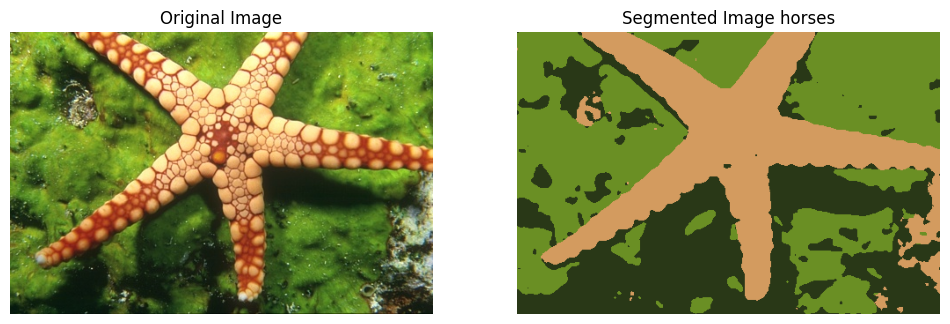

In [21]:
# Example usage
data = skimage.io.imread('/content/drive/MyDrive/DATA_FRFCM/Images_BSDS/Images_réelles/12003.jpg')
#
center, U, obj_fcn, iter_n = frfcm_c(data, cluster_n=3, radius=3, w_size=3)

m, n = data.shape[:2]  # Assuming data is your original image

cluster_n=3

membership_matrices = []
for j in range(cluster_n):
    membership_matrix = U[:, j].reshape(m, n)  # Reshape for each cluster
    membership_matrices.append(membership_matrix)


image2=data.astype(np.float64)
segmented=fcm_image_color(data, membership_matrices)
#segmented_image_test = np.mean([membership_matrices[i][:, :] for i in range(2)], axis=0)

import matplotlib.pyplot as plt
from skimage import io


# Display the original and segmented images
plt.figure(figsize=(12, 6))
plt.subplot(1, 2 ,1)
plt.imshow(data.astype(np.uint8))
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(segmented)
plt.title('Segmented Image horses')
plt.axis('off')
# Save the color image
plt.imsave('/content/drive/MyDrive/DATA_FRFCM/Results_segmentation_BSDS/segmented_12003.png', segmented)
plt.show()

<ipython-input-6-e894b902560d>:70: FutureWarning: `selem` is a deprecated argument name for `reconstruction`. It will be removed in version 1.0. Please use `footprint` instead.
  data_rgb[:, :, i] = morphology.reconstruction(data[:, :, i], data[:, :, i], method='dilation', selem=selem)


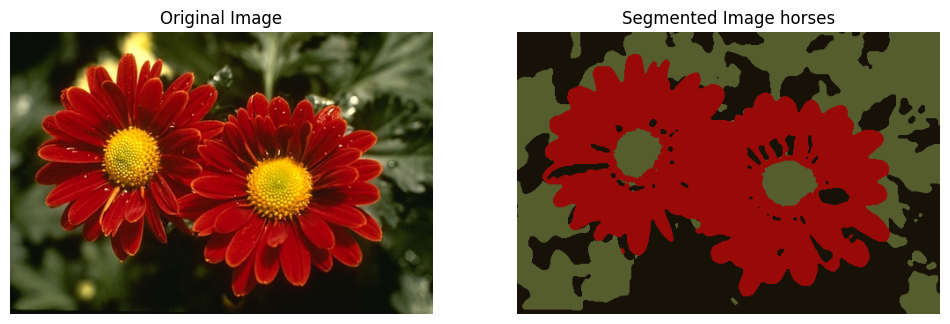

In [22]:
# Example usage
data = skimage.io.imread('/content/drive/MyDrive/DATA_FRFCM/Images_BSDS/Images_réelles/124084.jpg')
#
center, U, obj_fcn, iter_n = frfcm_c(data, cluster_n=3, radius=3, w_size=3)

m, n = data.shape[:2]  # Assuming data is your original image

cluster_n=3

membership_matrices = []
for j in range(cluster_n):
    membership_matrix = U[:, j].reshape(m, n)  # Reshape for each cluster
    membership_matrices.append(membership_matrix)


image2=data.astype(np.float64)
segmented=fcm_image_color(data, membership_matrices)
#segmented_image_test = np.mean([membership_matrices[i][:, :] for i in range(2)], axis=0)

import matplotlib.pyplot as plt
from skimage import io


# Display the original and segmented images
plt.figure(figsize=(12, 6))
plt.subplot(1, 2 ,1)
plt.imshow(data.astype(np.uint8))
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(segmented)
plt.title('Segmented Image horses')
plt.axis('off')
# Save the color image
plt.imsave('/content/drive/MyDrive/DATA_FRFCM/Results_segmentation_BSDS/segmented_124084.png', segmented)
plt.show()

<ipython-input-6-e894b902560d>:70: FutureWarning: `selem` is a deprecated argument name for `reconstruction`. It will be removed in version 1.0. Please use `footprint` instead.
  data_rgb[:, :, i] = morphology.reconstruction(data[:, :, i], data[:, :, i], method='dilation', selem=selem)


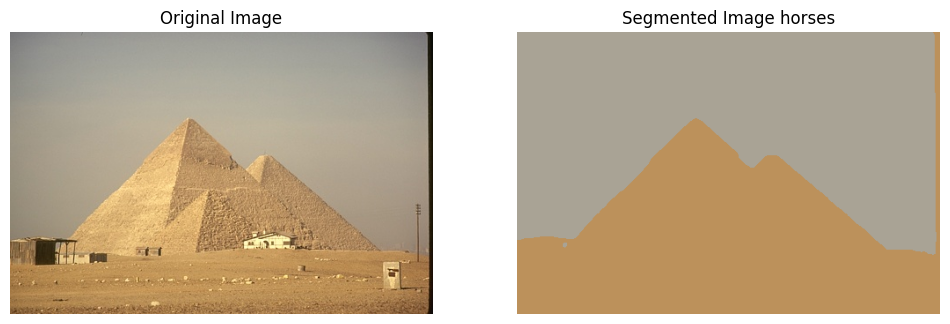

In [23]:
# Example usage
data = skimage.io.imread('/content/drive/MyDrive/DATA_FRFCM/Images_BSDS/Images_réelles/161062.jpg')
#
center, U, obj_fcn, iter_n = frfcm_c(data, cluster_n=2, radius=3, w_size=3)

m, n = data.shape[:2]  # Assuming data is your original image

cluster_n=2

membership_matrices = []
for j in range(cluster_n):
    membership_matrix = U[:, j].reshape(m, n)  # Reshape for each cluster
    membership_matrices.append(membership_matrix)


image2=data.astype(np.float64)
segmented=fcm_image_color(data, membership_matrices)
#segmented_image_test = np.mean([membership_matrices[i][:, :] for i in range(2)], axis=0)

import matplotlib.pyplot as plt
from skimage import io


# Display the original and segmented images
plt.figure(figsize=(12, 6))
plt.subplot(1, 2 ,1)
plt.imshow(data.astype(np.uint8))
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(segmented)
plt.title('Segmented Image horses')
plt.axis('off')
# Save the color image
plt.imsave('/content/drive/MyDrive/DATA_FRFCM/Results_segmentation_BSDS/segmented_161062.png', segmented)
plt.show()

<ipython-input-6-e894b902560d>:70: FutureWarning: `selem` is a deprecated argument name for `reconstruction`. It will be removed in version 1.0. Please use `footprint` instead.
  data_rgb[:, :, i] = morphology.reconstruction(data[:, :, i], data[:, :, i], method='dilation', selem=selem)


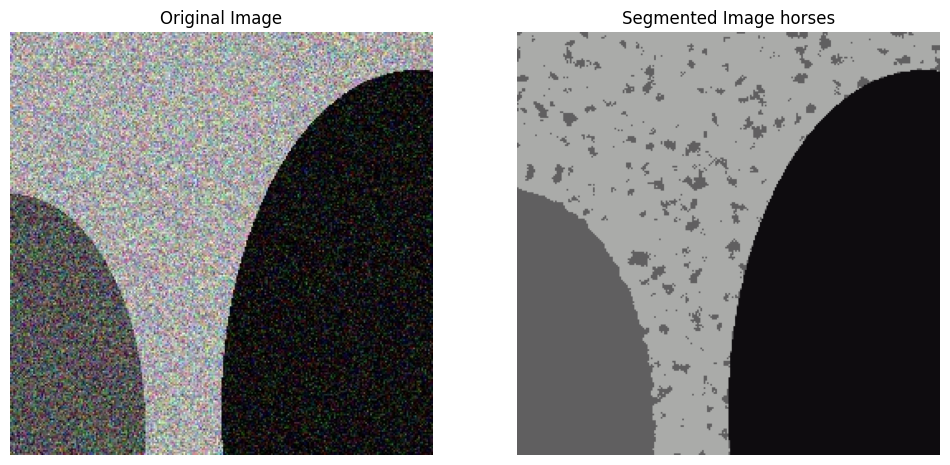

Accuracy: 0.3547859191894531


In [28]:
# Example usage
data = skimage.io.imread('/content/drive/MyDrive/DATA_FRFCM/Images_synthetiques/Images_avec_bruits/s1_with_bruit_3%gaussian (1).jpeg')
#
center, U, obj_fcn, iter_n = frfcm_c(data, cluster_n=3, radius=3, w_size=3)

m, n = data.shape[:2]  # Assuming data is your original image

cluster_n=3

membership_matrices = []
for j in range(cluster_n):
    membership_matrix = U[:, j].reshape(m, n)  # Reshape for each cluster
    membership_matrices.append(membership_matrix)


image2=data.astype(np.float64)
segmented=fcm_image_color(data, membership_matrices)
#segmented_image_test = np.mean([membership_matrices[i][:, :] for i in range(2)], axis=0)

import matplotlib.pyplot as plt
from skimage import io


# Display the original and segmented images
plt.figure(figsize=(12, 6))
plt.subplot(1, 2 ,1)
plt.imshow(data.astype(np.uint8))
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(segmented)
plt.title('Segmented Image horses')
plt.axis('off')
# Save the color image
plt.imsave('/content/drive/MyDrive/DATA_FRFCM/Results_segmentation_synthetique/segmented_s1_gaussian.png', segmented)
plt.show()


def calculate_segmentation_accuracy(segmented_image, ground_truth):
    # Check if the images have the same dimensions
    if segmented_image.shape != ground_truth.shape:
        raise ValueError("Segmented image and ground truth must have the same dimensions")

    total_pixels = segmented_image.size
    num_clusters = max(segmented_image.max(), ground_truth.max()) + 1

    accuracy = 0

    for cluster_num in range(num_clusters):
        # Create masks for the current cluster for both images
        segmented_cluster = segmented_image == cluster_num
        ground_truth_cluster = ground_truth == cluster_num

        # Calculate the intersection
        intersection = np.logical_and(segmented_cluster, ground_truth_cluster)
        accuracy += np.sum(intersection)

    return accuracy / total_pixels


from PIL import Image
# Load the ground truth and segmented images
ground_truth_img = Image.open("/content/drive/MyDrive/DATA_FRFCM/Images_synthetiques/Ground_truth/s1_ground_truth.png")
segmented_img = Image.open("/content/drive/MyDrive/DATA_FRFCM/Results_segmentation_synthetique/segmented_s1_gaussian.png")

# Convert images to numpy arrays
ground_truth = np.array(ground_truth_img)
segmented = np.array(segmented_img)

# Calculate the accuracy
accuracy = calculate_segmentation_accuracy(segmented, ground_truth)
print(f"Accuracy: {accuracy}")



<ipython-input-6-e894b902560d>:70: FutureWarning: `selem` is a deprecated argument name for `reconstruction`. It will be removed in version 1.0. Please use `footprint` instead.
  data_rgb[:, :, i] = morphology.reconstruction(data[:, :, i], data[:, :, i], method='dilation', selem=selem)


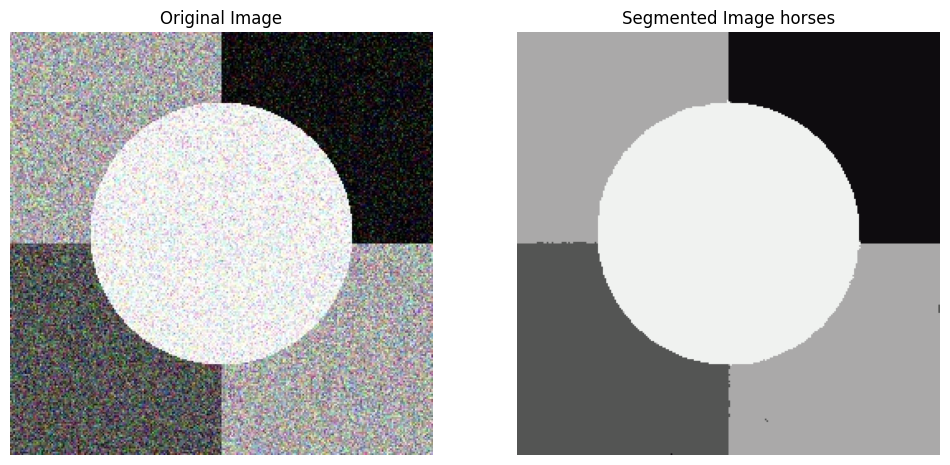

Accuracy: 0.38236236572265625


In [30]:
# Example usage
data = skimage.io.imread('/content/drive/MyDrive/DATA_FRFCM/Images_synthetiques/Images_avec_bruits/s2_with_bruit_3%gaussian.jpeg')
#
center, U, obj_fcn, iter_n = frfcm_c(data, cluster_n=4, radius=3, w_size=3)

m, n = data.shape[:2]  # Assuming data is your original image

cluster_n=4

membership_matrices = []
for j in range(cluster_n):
    membership_matrix = U[:, j].reshape(m, n)  # Reshape for each cluster
    membership_matrices.append(membership_matrix)


image2=data.astype(np.float64)
segmented=fcm_image_color(data, membership_matrices)
#segmented_image_test = np.mean([membership_matrices[i][:, :] for i in range(2)], axis=0)

import matplotlib.pyplot as plt
from skimage import io


# Display the original and segmented images
plt.figure(figsize=(12, 6))
plt.subplot(1, 2 ,1)
plt.imshow(data.astype(np.uint8))
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(segmented)
plt.title('Segmented Image horses')
plt.axis('off')
# Save the color image
plt.imsave('/content/drive/MyDrive/DATA_FRFCM/Results_segmentation_synthetique/segmented_s2_gaussian.png', segmented)
plt.show()


def calculate_segmentation_accuracy(segmented_image, ground_truth):
    # Check if the images have the same dimensions
    if segmented_image.shape != ground_truth.shape:
        raise ValueError("Segmented image and ground truth must have the same dimensions")

    total_pixels = segmented_image.size
    num_clusters = max(segmented_image.max(), ground_truth.max()) + 1

    accuracy = 0

    for cluster_num in range(num_clusters):
        # Create masks for the current cluster for both images
        segmented_cluster = segmented_image == cluster_num
        ground_truth_cluster = ground_truth == cluster_num

        # Calculate the intersection
        intersection = np.logical_and(segmented_cluster, ground_truth_cluster)
        accuracy += np.sum(intersection)

    return accuracy / total_pixels

import numpy as np


from PIL import Image
# Load the ground truth and segmented images
ground_truth_img = Image.open("/content/drive/MyDrive/DATA_FRFCM/Images_synthetiques/Ground_truth/s2_ground_truth.png")
segmented_img = Image.open("/content/drive/MyDrive/DATA_FRFCM/Results_segmentation_synthetique/segmented_s2_gaussian.png")

# Convert images to numpy arrays
ground_truth = np.array(ground_truth_img)
segmented = np.array(segmented_img)

# Calculate the accuracy
accuracy = calculate_segmentation_accuracy(segmented, ground_truth)
print(f"Accuracy: {accuracy}")



<ipython-input-6-e894b902560d>:70: FutureWarning: `selem` is a deprecated argument name for `reconstruction`. It will be removed in version 1.0. Please use `footprint` instead.
  data_rgb[:, :, i] = morphology.reconstruction(data[:, :, i], data[:, :, i], method='dilation', selem=selem)


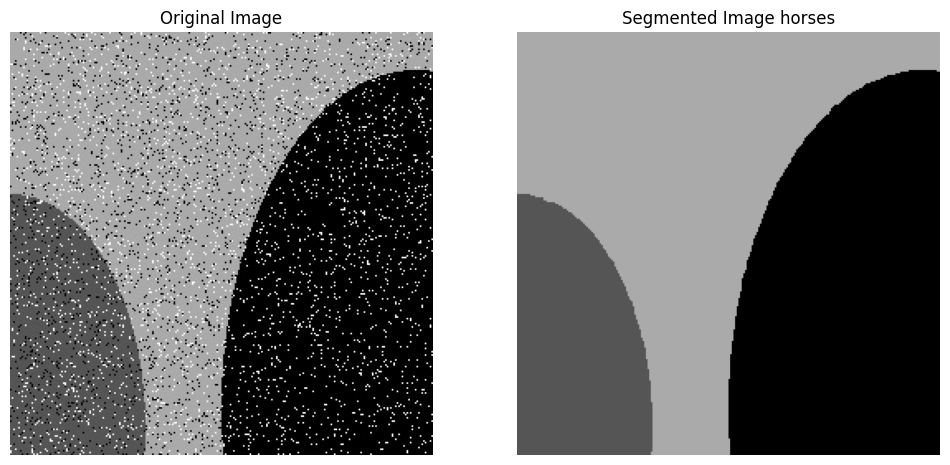

Accuracy: 0.9992790222167969


In [31]:
# Example usage
data = skimage.io.imread('/content/drive/MyDrive/DATA_FRFCM/Images_synthetiques/Images_avec_bruits/s1_with_bruit_salt.jpg')
#
center, U, obj_fcn, iter_n = frfcm_c(data, cluster_n=3, radius=3, w_size=3)

m, n = data.shape[:2]  # Assuming data is your original image

cluster_n=3

membership_matrices = []
for j in range(cluster_n):
    membership_matrix = U[:, j].reshape(m, n)  # Reshape for each cluster
    membership_matrices.append(membership_matrix)


image2=data.astype(np.float64)
segmented=fcm_image_color(data, membership_matrices)
#segmented_image_test = np.mean([membership_matrices[i][:, :] for i in range(2)], axis=0)

import matplotlib.pyplot as plt
from skimage import io


# Display the original and segmented images
plt.figure(figsize=(12, 6))
plt.subplot(1, 2 ,1)
plt.imshow(data.astype(np.uint8))
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(segmented)
plt.title('Segmented Image horses')
plt.axis('off')
# Save the color image
plt.imsave('/content/drive/MyDrive/DATA_FRFCM/Results_segmentation_synthetique/segmented_s1_salt.png', segmented)
plt.show()


def calculate_segmentation_accuracy(segmented_image, ground_truth):
    # Check if the images have the same dimensions
    if segmented_image.shape != ground_truth.shape:
        raise ValueError("Segmented image and ground truth must have the same dimensions")

    total_pixels = segmented_image.size
    num_clusters = max(segmented_image.max(), ground_truth.max()) + 1

    accuracy = 0

    for cluster_num in range(num_clusters):
        # Create masks for the current cluster for both images
        segmented_cluster = segmented_image == cluster_num
        ground_truth_cluster = ground_truth == cluster_num

        # Calculate the intersection
        intersection = np.logical_and(segmented_cluster, ground_truth_cluster)
        accuracy += np.sum(intersection)

    return accuracy / total_pixels

import numpy as np


from PIL import Image
# Load the ground truth and segmented images
ground_truth_img = Image.open("/content/drive/MyDrive/DATA_FRFCM/Images_synthetiques/Ground_truth/s1_ground_truth.png")
segmented_img = Image.open("/content/drive/MyDrive/DATA_FRFCM/Results_segmentation_synthetique/segmented_s1_salt.png")

# Convert images to numpy arrays
ground_truth = np.array(ground_truth_img)
segmented = np.array(segmented_img)

# Calculate the accuracy
accuracy = calculate_segmentation_accuracy(segmented, ground_truth)
print(f"Accuracy: {accuracy}")

<ipython-input-6-e894b902560d>:70: FutureWarning: `selem` is a deprecated argument name for `reconstruction`. It will be removed in version 1.0. Please use `footprint` instead.
  data_rgb[:, :, i] = morphology.reconstruction(data[:, :, i], data[:, :, i], method='dilation', selem=selem)


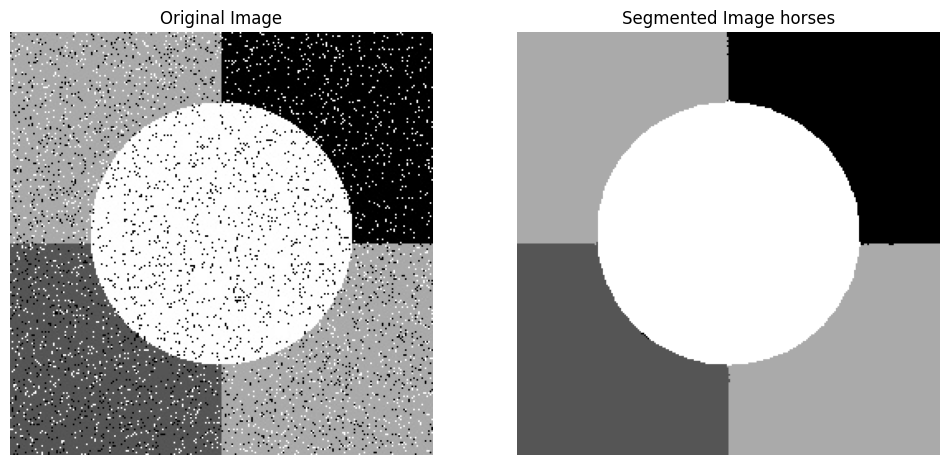

Accuracy: 0.9987068176269531


In [33]:
# Example usage
data = skimage.io.imread('/content/drive/MyDrive/DATA_FRFCM/Images_synthetiques/Images_avec_bruits/s2_with_bruit_salt.png')
#
center, U, obj_fcn, iter_n = frfcm_c(data, cluster_n=4, radius=3, w_size=3)

m, n = data.shape[:2]  # Assuming data is your original image

cluster_n=4

membership_matrices = []
for j in range(cluster_n):
    membership_matrix = U[:, j].reshape(m, n)  # Reshape for each cluster
    membership_matrices.append(membership_matrix)


image2=data.astype(np.float64)
segmented=fcm_image_color(data, membership_matrices)
#segmented_image_test = np.mean([membership_matrices[i][:, :] for i in range(2)], axis=0)

import matplotlib.pyplot as plt
from skimage import io


# Display the original and segmented images
plt.figure(figsize=(12, 6))
plt.subplot(1, 2 ,1)
plt.imshow(data.astype(np.uint8))
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(segmented)
plt.title('Segmented Image horses')
plt.axis('off')
# Save the color image
plt.imsave('/content/drive/MyDrive/DATA_FRFCM/Results_segmentation_synthetique/segmented_s2_salt.png', segmented)
plt.show()


def calculate_segmentation_accuracy(segmented_image, ground_truth):
    # Check if the images have the same dimensions
    if segmented_image.shape != ground_truth.shape:
        raise ValueError("Segmented image and ground truth must have the same dimensions")

    total_pixels = segmented_image.size
    num_clusters = max(segmented_image.max(), ground_truth.max()) + 1

    accuracy = 0

    for cluster_num in range(num_clusters):
        # Create masks for the current cluster for both images
        segmented_cluster = segmented_image == cluster_num
        ground_truth_cluster = ground_truth == cluster_num

        # Calculate the intersection
        intersection = np.logical_and(segmented_cluster, ground_truth_cluster)
        accuracy += np.sum(intersection)

    return accuracy / total_pixels

import numpy as np


from PIL import Image
# Load the ground truth and segmented images
ground_truth_img = Image.open("/content/drive/MyDrive/DATA_FRFCM/Images_synthetiques/Ground_truth/s2_ground_truth.png")
segmented_img = Image.open("/content/drive/MyDrive/DATA_FRFCM/Results_segmentation_synthetique/segmented_s2_salt.png")

# Convert images to numpy arrays
ground_truth = np.array(ground_truth_img)
segmented = np.array(segmented_img)

# Calculate the accuracy
accuracy = calculate_segmentation_accuracy(segmented, ground_truth)
print(f"Accuracy: {accuracy}")

<ipython-input-6-e894b902560d>:70: FutureWarning: `selem` is a deprecated argument name for `reconstruction`. It will be removed in version 1.0. Please use `footprint` instead.
  data_rgb[:, :, i] = morphology.reconstruction(data[:, :, i], data[:, :, i], method='dilation', selem=selem)


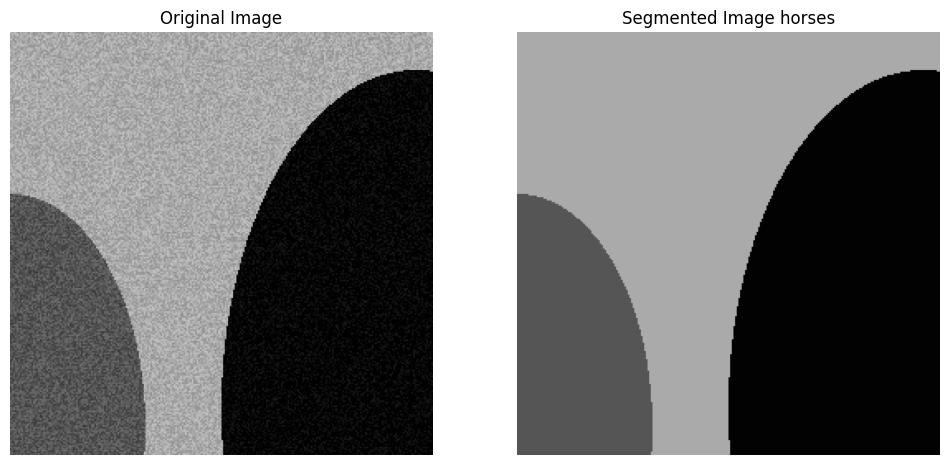

Accuracy: 0.7181663513183594


In [34]:
# Example usage
data = skimage.io.imread('/content/drive/MyDrive/DATA_FRFCM/Images_synthetiques/Images_avec_bruits/s1_with_bruit_uniform.png')
#
center, U, obj_fcn, iter_n = frfcm_c(data, cluster_n=3, radius=3, w_size=3)

m, n = data.shape[:2]  # Assuming data is your original image

cluster_n=3

membership_matrices = []
for j in range(cluster_n):
    membership_matrix = U[:, j].reshape(m, n)  # Reshape for each cluster
    membership_matrices.append(membership_matrix)


image2=data.astype(np.float64)
segmented=fcm_image_color(data, membership_matrices)
#segmented_image_test = np.mean([membership_matrices[i][:, :] for i in range(2)], axis=0)

import matplotlib.pyplot as plt
from skimage import io


# Display the original and segmented images
plt.figure(figsize=(12, 6))
plt.subplot(1, 2 ,1)
plt.imshow(data.astype(np.uint8))
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(segmented)
plt.title('Segmented Image horses')
plt.axis('off')
# Save the color image
plt.imsave('/content/drive/MyDrive/DATA_FRFCM/Results_segmentation_synthetique/segmented_s1_uniform.png', segmented)
plt.show()


def calculate_segmentation_accuracy(segmented_image, ground_truth):
    # Check if the images have the same dimensions
    if segmented_image.shape != ground_truth.shape:
        raise ValueError("Segmented image and ground truth must have the same dimensions")

    total_pixels = segmented_image.size
    num_clusters = max(segmented_image.max(), ground_truth.max()) + 1

    accuracy = 0

    for cluster_num in range(num_clusters):
        # Create masks for the current cluster for both images
        segmented_cluster = segmented_image == cluster_num
        ground_truth_cluster = ground_truth == cluster_num

        # Calculate the intersection
        intersection = np.logical_and(segmented_cluster, ground_truth_cluster)
        accuracy += np.sum(intersection)

    return accuracy / total_pixels

import numpy as np


from PIL import Image
# Load the ground truth and segmented images
ground_truth_img = Image.open("/content/drive/MyDrive/DATA_FRFCM/Images_synthetiques/Ground_truth/s1_ground_truth.png")
segmented_img = Image.open("/content/drive/MyDrive/DATA_FRFCM/Results_segmentation_synthetique/segmented_s1_uniform.png")

# Convert images to numpy arrays
ground_truth = np.array(ground_truth_img)
segmented = np.array(segmented_img)

# Calculate the accuracy
accuracy = calculate_segmentation_accuracy(segmented, ground_truth)
print(f"Accuracy: {accuracy}")

<ipython-input-6-e894b902560d>:70: FutureWarning: `selem` is a deprecated argument name for `reconstruction`. It will be removed in version 1.0. Please use `footprint` instead.
  data_rgb[:, :, i] = morphology.reconstruction(data[:, :, i], data[:, :, i], method='dilation', selem=selem)


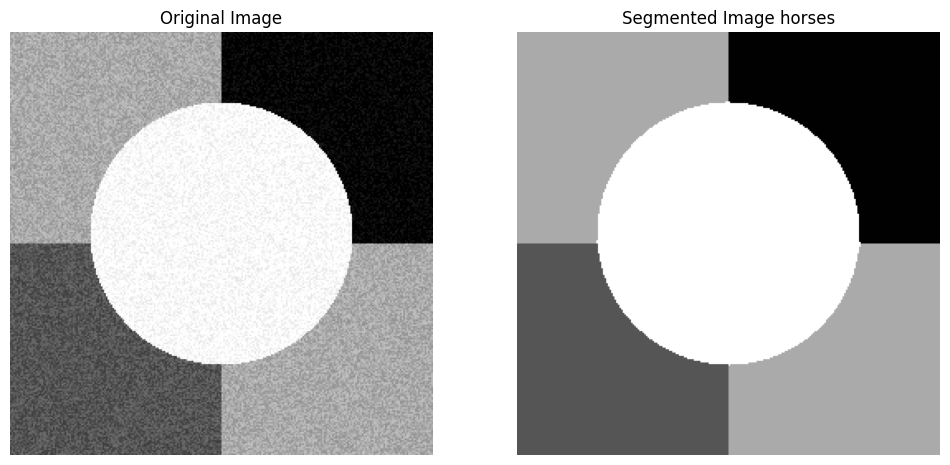

Accuracy: 0.8744010925292969


In [36]:
# Example usage
data = skimage.io.imread('/content/drive/MyDrive/DATA_FRFCM/Images_synthetiques/Images_avec_bruits/s2_with_bruit_uniform.png')
#
center, U, obj_fcn, iter_n = frfcm_c(data, cluster_n=4, radius=3, w_size=3)

m, n = data.shape[:2]  # Assuming data is your original image

cluster_n=4

membership_matrices = []
for j in range(cluster_n):
    membership_matrix = U[:, j].reshape(m, n)  # Reshape for each cluster
    membership_matrices.append(membership_matrix)


image2=data.astype(np.float64)
segmented=fcm_image_color(data, membership_matrices)
#segmented_image_test = np.mean([membership_matrices[i][:, :] for i in range(2)], axis=0)

import matplotlib.pyplot as plt
from skimage import io


# Display the original and segmented images
plt.figure(figsize=(12, 6))
plt.subplot(1, 2 ,1)
plt.imshow(data.astype(np.uint8))
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(segmented)
plt.title('Segmented Image horses')
plt.axis('off')
# Save the color image
plt.imsave('/content/drive/MyDrive/DATA_FRFCM/Results_segmentation_synthetique/segmented_s2_uniform.png', segmented)
plt.show()


def calculate_segmentation_accuracy(segmented_image, ground_truth):
    # Check if the images have the same dimensions
    if segmented_image.shape != ground_truth.shape:
        raise ValueError("Segmented image and ground truth must have the same dimensions")

    total_pixels = segmented_image.size
    num_clusters = max(segmented_image.max(), ground_truth.max()) + 1

    accuracy = 0

    for cluster_num in range(num_clusters):
        # Create masks for the current cluster for both images
        segmented_cluster = segmented_image == cluster_num
        ground_truth_cluster = ground_truth == cluster_num

        # Calculate the intersection
        intersection = np.logical_and(segmented_cluster, ground_truth_cluster)
        accuracy += np.sum(intersection)

    return accuracy / total_pixels

import numpy as np


from PIL import Image
# Load the ground truth and segmented images
ground_truth_img = Image.open("/content/drive/MyDrive/DATA_FRFCM/Images_synthetiques/Ground_truth/s2_ground_truth.png")
segmented_img = Image.open("/content/drive/MyDrive/DATA_FRFCM/Results_segmentation_synthetique/segmented_s2_uniform.png")

# Convert images to numpy arrays
ground_truth = np.array(ground_truth_img)
segmented = np.array(segmented_img)

# Calculate the accuracy
accuracy = calculate_segmentation_accuracy(segmented, ground_truth)
print(f"Accuracy: {accuracy}")